# Introduction
In this notebook, we provide examples and explanations about the usage of our implementation of the Lindblad equation proposed in [this paper](https://arxiv.org/abs/2402.06354). The main idea there is to find a transformation that turns the Bloch-Redfield equation (BRE) into a Lindblad master equation (LME), keeping the couplings that the secular approximation neglects and preserving the accuracy of the BRE. The main reason behind our efforts is to overcome the mathematical limitations of the BRE (it does not guarantee that the density matrix remains positive semidefinite at all times).

Our implementation should be compatible with recent versions of QuTiP (only tested with version 4.7.5), and uses it extensively. As such, it can be considered a modest extension of the package.

In [1]:
# file with our implementation
from src.lindbladAG import mesolveAG, old_brmesolve
# necessary qutip imports only
from qutip import Qobj, basis, brmesolve
# other useful imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
# custom matplotlib style 
plt.style.use("src/style.mplstyle")
# conversion for times from 1/eV to fs
inv_eV_to_fs = 0.658


# Example 1: Comparison with qutip's brmesolve (no cross-correlations and no Lamb-shift)


## System's parameters
We first create a random system with a fixed number of levels ($L$, `nLevels`) and connected to a number of baths ($K$, `nOperators`). We build the Hamiltonian `H` and a list of operators coupling the system to the baths `a_ops`. All of these have to be Hermitian, just like in QuTiP's implementation of the BRE. Additionally, the system's Hamiltonian does not need to be diagonal, but we restrict the size of the off-diagonal couplings to ensure that the timescale induced by the coupling to the environment is at least comparable to the timescale of the intrinsic couplings of the system, such that the former is not overshadowed by the latter. 

In [2]:
# size of system
nLevels = 4
nOperators = 2

# fix the seed for reproducibility
np.random.seed(12346789)

# Hamiltonian (hermitian but not diagonal)
H = Qobj((h:=np.random.rand(nLevels, nLevels))*0.05 + h.T*0.05 + np.diag(np.diagonal(h)))
evals = H.eigenenergies()

# Operators mediating system-bath interactions
a_ops = []
for i in range(nOperators):
    op = np.random.rand(nLevels, nLevels)
    op += op.T
    a_ops.append(Qobj(op))
H

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.61312539 0.01193694 0.07457166 0.05007917]
 [0.01193694 0.52063743 0.03848605 0.0514774 ]
 [0.07457166 0.03848605 0.65722849 0.04740586]
 [0.05007917 0.0514774  0.04740586 0.73006571]]

## Baths' parameters
Following the same approach as in the second part of [this paper](https://arxiv.org/abs/2402.06354), we generate a positive semidefinite, matrix valued function that takes energy as argument with the expression
\begin{equation*}
    \mathbf{J}(\hbar\omega) = \frac\hbar\pi \mathbf{g} \cdot \mathrm{Im}\left(\mathbf{h} - \omega\right)^{-1}\cdot \mathbf{g}^T,
\end{equation*}
where $\mathbf{J}$ is a $K\times K$ matrix. Here, $\mathbf{h}$ and $\mathbf{g}$ are $N\times N$ and $K\times N$ matrices, respectively. We also set $\mathrm{Re}\{\mathbf{h}\}$ and $\mathrm{Im}\{\mathbf{h}\}$ to be symmetric and diagonal matrices. We then choose the parameters in $\mathbf{g}$ and $\mathbf{h}$ randomly, subject to the above restrictions, and thus generate physically consistent spectral densities, $\mathbf{J}$, albeit with off-diagonal terms. Since we don't want to treat bath cross-correlations in this first example, we simply remove the off-diagonal elements from $\mathrm{J}$ after creating it with the above expression.

In the code below, we create `J`, an array of SciPy interpolators that plays the role of spectral density. Even though our implementation can deal with cross-correlations, where a square array of interpolators is needed, we have included a simplified way to represent non-cross-correlated environments with a 1-dimensional array, as done below. In the next examples, we will show the usage of the more general approach.

In [3]:
# parameters for the spectral densities:
# number of modes
nModes = 5

# mode energies
energies = np.random.rand(nModes) * (2*max(evals) - min(evals)) + max(min(evals), 0.0)
np.ndarray.sort(energies)

# couplings between the modes
couplings = ((c:=np.random.rand(nModes, nModes)) + c.T - 2 * np.diag(np.diagonal(c))) * 0.5

# decay rates of the modes
κi = np.random.rand(nModes) * (0.5 - 0.2) + 1.0

# full h matrix
h = np.diag(energies) + couplings - 0.5j * np.diag(κi)

# couplings to the system
g = np.random.rand(nOperators, nModes) * np.sqrt(0.01)

# array of interpolators to hold the spectral density
J = np.empty(nOperators, dtype=object)

# array of interpolators to hold the spectral function for brmesolve (S = 2π·J)
S = np.empty(nOperators, dtype=object)

# x-axis for the interpolation
energy = np.linspace(-10, 10, 500)

# array with values to interpolate
J_arr = 1 / np.pi * g @ np.linalg.inv(h - energy[:, np.newaxis, np.newaxis] * np.identity(nModes)).imag @ g.T
for i in range(nOperators):
    J[i] = interp1d(energy, J_arr[:, i, i], 
                    bounds_error=False, fill_value=0) 
    S[i] = interp1d(energy, 2*np.pi*J_arr[:, i, i], 
                    bounds_error=False, fill_value=0) 

Text(0.5, 1.0, 'Spectral densities')

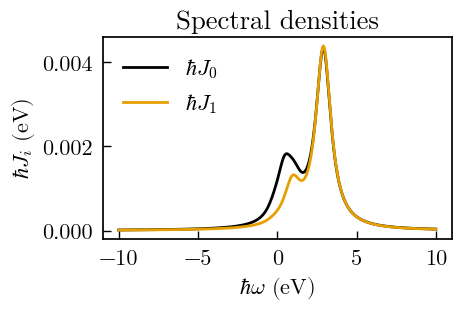

In [4]:
# plot of the spectral densities
for i, j in enumerate(J):
    plt.plot(energy, j(energy), label=f"$\hbar J_{i}$")
plt.legend()
plt.xlabel("$\hbar\omega$ (eV)")
plt.ylabel("$\hbar J_i$ (eV)")
plt.title("Spectral densities")

## Time evolution
Once the system and baths have been characterized, we solve the temporal evolution of the populations with both QuTiP's `brmesolve` and our implementation of the method of [this paper](https://arxiv.org/abs/2402.06354). Our implementation is accessed throught the function `mesolveAG`, in reference to the arithmetic and geometric means that are used to construct the Liouvillian. The main difference with respect to the `brmesolve` function call is how the spectral functions are passed. In `brmesolve`, the argument `a_ops` is a nested list of operators and their corresponding bath spectral function, whereas in `mesolveAG` we have separate arguments for the operators (`a_ops`) and bath functions (`J`). Additionally, in QuTiP's implementation of `brmesolve`, the spectral functions are related to our spectral density through $\mathbf{S} = 2\pi \mathbf{J}$. Since the `J` instance defined above is an array of interpolators, multiplication by scalars is not supported and the $2\pi$ factor is included in the operators `a_opsBR` below.

In [5]:
# initial state: chosen randomly
psi0 = 0
for i in range(nLevels):
    psi0 += np.random.rand() * basis(nLevels, i)
psi0 = psi0.unit()

# time array
t = np.linspace(0, 200, 1500)

# expectation operators (populations)
e_ops = [basis(nLevels, i) * basis(nLevels, i).dag() for i in range(nLevels)]

# 1. Bloch-Redfield
a_opsBR = [[a, s] for a, s in zip(a_ops, S)]
rhoBR = brmesolve(H=H, psi0=psi0, tlist=t, a_ops=a_opsBR, 
                  e_ops=e_ops, use_secular=False).expect

# 2. Arithmetic-Geometric master equation
# comparable syntax. use_secular=False is the default option here.
rhoAG = mesolveAG(H=H, psi0=psi0, tlist=t, a_ops=a_ops, 
                  J=J, e_ops=e_ops, use_secular=False).expect

Text(0.5, 0, '$t$ (fs)')

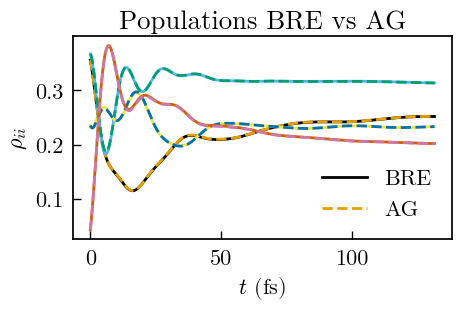

In [6]:
for i, (pBR, pAG) in enumerate(zip(rhoBR, rhoAG)):
    plt.plot(t * inv_eV_to_fs, pBR.real, label="BRE"*(i==0))
    plt.plot(t * inv_eV_to_fs, pAG.real, "--", label="AG"*(i==0))
plt.legend()
plt.title("Populations BRE vs AG")
plt.ylabel(r"$\rho_{ii}$")
plt.xlabel("$t$ (fs)")

As can be seen from the previous figure, the agreement between the BRE and the arithmetic-geometric master equation from [this paper](https://arxiv.org/abs/2402.06354) is perfect. 

# Example 2: Lamb shift

The implementation of the Lamb shift in our method is quite simple. In practice, if the `L` argument (an array of callable objects) is provided, the Lamb shift is calculated and included in the Liouvillian. `L` represents
\begin{equation*}
    \boldsymbol{\lambda}(\hbar\omega) = \mathrm{P}\int_{-\infty}^\infty \mathrm{d}\omega'\ \frac{\mathbf{J}(\hbar\omega')}{\omega-\omega'},
\end{equation*}
which has an analytic expression for the model spectral density used above:
\begin{equation*}
    \boldsymbol{\lambda}(\hbar\omega) = -\hbar \mathbf{g}\cdot \mathrm{Re}(\mathbf{h}-\omega)^{-1}\cdot g^T.
\end{equation*}

For the comparison with a known method, we run into the problem that the default implementation of `brmesolve` cannot handle Lamb shifts, and assumes them to be negligible while creating the Bloch-Redfield tensor with `bloch_redfield_tensor`. In principle, a minor modification to the `bloch_redfield_tensor` function would allow for the inclusion of the Lamb shift: it suffices to pass a complex spectral function given by 
\begin{equation*}
\tilde{\mathbf{S}} = 2\pi\mathbf{J} + 2i \boldsymbol{\lambda}
\end{equation*}
and adding a `.conj()` in a couple of lines of the code. However, as of QuTiP's 4.3 version, the `bloch_redfield_tensor` function has been moved to a cython file whose modification is more complicated. For that reason, we rescue in our `lindbladAG.py` file the previous version of `bloch_redfield_tensor`, named for clarity `old_bloch_redfield_tensor`, and modify it to account for the Lamb shift.

Together with `old_bloch_redfield_tensor`, we include `old_bloch_redfield_solve` and `old_brmesolve`, to avoid relying on QuTiP's current versions of these functions and any incompatibility that may follow. In the example below, we use this modified function from older QuTiP versions to simulate a system coupled to a set of non-cross-correlated baths, and compare with our master equation. We set the random seed to the same value to better emphasize the effect of the Lamb shift in this system, and the accuracy to which the arithmetic-geometric master equation reproduces it.



In [7]:
# size of system
nLevels = 4
nOperators = 2

# fix the seed for reproducibility.
# same seed as in Example 1, to better appreciate the effect of the Lamb shift
np.random.seed(12346789)

# Hamiltonian (hermitian but not diagonal)
H = Qobj((h:=np.random.rand(nLevels, nLevels))*0.05 + h.T*0.05 + np.diag(np.diagonal(h)))
evals = H.eigenenergies()

# Operators mediating system-bath interactions
a_ops = []
for i in range(nOperators):
    op = np.random.rand(nLevels, nLevels)
    op += op.T
    a_ops.append(Qobj(op))
H

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.61312539 0.01193694 0.07457166 0.05007917]
 [0.01193694 0.52063743 0.03848605 0.0514774 ]
 [0.07457166 0.03848605 0.65722849 0.04740586]
 [0.05007917 0.0514774  0.04740586 0.73006571]]

In [8]:
# parameters for the spectral densities:
# number of modes
nModes = 5

# mode energies
energies = np.random.rand(nModes) * (2*max(evals) - min(evals)) + max(min(evals), 0.0)
np.ndarray.sort(energies)

# couplings between the modes
couplings = ((c:=np.random.rand(nModes, nModes)) + c.T - 2 * np.diag(np.diagonal(c))) * 0.5

# decay rates of the modes
κi = np.random.rand(nModes) * (0.5 - 0.2) + 1.0

# full h matrix
h = np.diag(energies) + couplings - 0.5j * np.diag(κi)

# couplings to the system
g = np.random.rand(nOperators, nModes) * np.sqrt(0.01)

# array of interpolators to hold the spectral density
J = np.empty(nOperators, dtype=object)

# array of interpolators to hold the spectral function for brmesolve (S = 2π·J)
S = np.empty(nOperators, dtype=object)

# x-axis for the interpolation
energy = np.linspace(-10, 10, 500)

# spectral functions for our arithmetic-geometric Lindblad master equation:
# arrays of real-valued interpolators
J = np.empty(nOperators, dtype=object)
L = np.empty(nOperators, dtype=object)

# spectral functions for old_brmesolve: 
# arrays of complex valued interpolators 2π·J + 2i·λ
Si2L = np.empty(nOperators, dtype=object)

# fill arrays to interpolate
J_arr = 1 / np.pi * g @ np.linalg.inv(h - energy[:, np.newaxis, np.newaxis] * np.identity(nModes)).imag @ g.T
L_arr = - g @ np.linalg.inv(h - energy[:, np.newaxis, np.newaxis] * np.identity(nModes)).real @ g.T

# interpolate spectral density, spectral integral, 
# and the combination for brmesolve
for i in range(nOperators):
    J[i] = interp1d(energy, J_arr[:, i, i], 
                    bounds_error=False, fill_value=0) 
    L[i] = interp1d(energy, L_arr[:, i, i], 
                    bounds_error=False, fill_value=0) 
    # given the implementation, the Lamb shift part must include a 2j factor
    Si2L[i] = interp1d(energy, 2*np.pi * J_arr[:, i, i] + 2j * L_arr[:, i, i], 
                       bounds_error=False, fill_value=0)

Text(0.5, 1.0, 'Spectral functions')

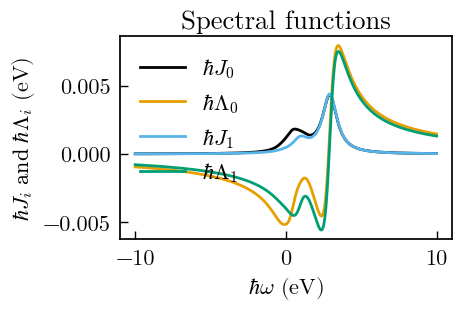

In [9]:
for i, (j, l) in enumerate(zip(J, L)):
    plt.plot(energy, j(energy), label=f"$\hbar J_{i}$")
    plt.plot(energy, l(energy), label=f"$\hbar\Lambda_{i}$")
plt.legend(loc="upper left")
plt.xlabel("$\hbar\omega$ (eV)")
plt.ylabel("$\hbar J_i\ \mathrm{and}\ \hbar\Lambda_i$ (eV)")
plt.title("Spectral functions")

In [10]:
# initial state: chosen randomly
psi0 = 0
for i in range(nLevels):
    psi0 += np.random.rand() * basis(nLevels, i)
psi0 = psi0.unit()

# time array
t = np.linspace(0, 200, 1500)

# expectation operators (populations)
e_ops = [basis(nLevels, i) * basis(nLevels, i).dag() for i in range(nLevels)]

# 1. Old Bloch-Redfield
rhoBR_LS = old_brmesolve(H=H, psi0=psi0, tlist=t, a_ops=a_ops, spectra_cb=Si2L, e_ops=e_ops, use_secular=False).expect

# 2. Arithmetic-Geometric master equation
# comparable syntax. use_secular=False is the default option here.
rhoAG = mesolveAG(H=H, psi0=psi0, tlist=t, a_ops=a_ops, J=J, L=L, e_ops=e_ops, use_secular=False).expect

Text(0.5, 0, '$t$ (fs)')

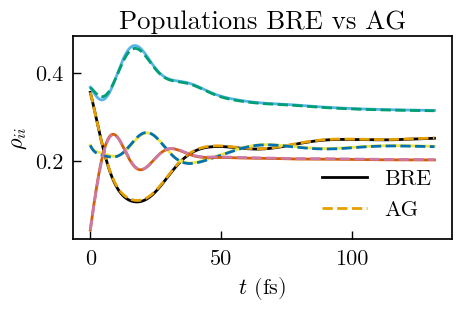

In [11]:
for i, (pBR_LS, pAG) in enumerate(zip(rhoBR_LS, rhoAG)):
    plt.plot(t * inv_eV_to_fs, pBR_LS.real, label="BRE"*(i==0))
    plt.plot(t * inv_eV_to_fs, pAG.real, "--", label="AG"*(i==0))
plt.legend()
plt.title("Populations BRE vs AG")
plt.ylabel(r"$\rho_{ii}$")
plt.xlabel("$t$ (fs)")

Not only is the agreement very good in this case again, but the dynamics also looks quite different from the previous case without the Lamb shift. This indicates that the effect of the vacuum-induced couplings is not always negligible (for a particularly prominent example, take a look at [this other paper](https://scipost.org/SciPostPhys.15.6.252)).

# Example 3: Effect of cross-correlations

Here, we solve the dynamics with the full spectral functions, that is, including the off-diagonal terms. This way, we can compare with the solution without cross-correlations and notice their large impact in generic environments.

In [12]:
# size of system
nLevels = 4
nOperators = 2

# fix the seed for reproducibility.
# same seed as in Example 1, to better appreciate the effect of the Lamb shift
np.random.seed(12346789)

# Hamiltonian (hermitian but not diagonal)
H = Qobj((h:=np.random.rand(nLevels, nLevels))*0.05 + h.T*0.05 + np.diag(np.diagonal(h)))
evals = H.eigenenergies()

# Operators mediating system-bath interactions
a_ops = []
for i in range(nOperators):
    op = np.random.rand(nLevels, nLevels)
    op += op.T
    a_ops.append(Qobj(op))
H

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.61312539 0.01193694 0.07457166 0.05007917]
 [0.01193694 0.52063743 0.03848605 0.0514774 ]
 [0.07457166 0.03848605 0.65722849 0.04740586]
 [0.05007917 0.0514774  0.04740586 0.73006571]]

In [13]:
# parameters for the spectral densities:
# number of modes
nModes = 5

# mode energies
energies = np.random.rand(nModes) * (2*max(evals) - min(evals)) + max(min(evals), 0.0)
np.ndarray.sort(energies)

# couplings between the modes
couplings = ((c:=np.random.rand(nModes, nModes)) + c.T - 2 * np.diag(np.diagonal(c))) * 0.5

# decay rates of the modes
κi = np.random.rand(nModes) * (0.5 - 0.2) + 1.0

# full h matrix
h = np.diag(energies) + couplings - 0.5j * np.diag(κi)

# couplings to the system
g = np.random.rand(nOperators, nModes) * np.sqrt(0.01)

# array of interpolators to hold the spectral density
J = np.empty(nOperators, dtype=object)

# array of interpolators to hold the spectral function for brmesolve (S = 2π·J)
S = np.empty(nOperators, dtype=object)

# x-axis for the interpolation
energy = np.linspace(-10, 10, 500)

# spectral functions for our arithmetic-geometric Lindblad master equation:
# arrays of real-valued interpolators
J = np.empty((nOperators, nOperators), dtype=object)
L = np.empty((nOperators, nOperators), dtype=object)

# spectral functions for old_brmesolve: 
# arrays of complex valued interpolators 2π·J + 2i·λ
Si2L = np.empty(nOperators, dtype=object)

# fill arrays to interpolate
J_arr = 1 / np.pi * g @ np.linalg.inv(h - energy[:, np.newaxis, np.newaxis] * np.identity(nModes)).imag @ g.T
L_arr = - g @ np.linalg.inv(h - energy[:, np.newaxis, np.newaxis] * np.identity(nModes)).real @ g.T

# interpolate spectral density, spectral integral, 
# and the combination for brmesolve
for i in range(nOperators):
    for j in range(nOperators):
        J[i, j] = interp1d(energy, J_arr[:, i, j], 
                            bounds_error=False, fill_value=0) 
        L[i, j] = interp1d(energy, L_arr[:, i, j], 
                            bounds_error=False, fill_value=0) 
    # given the implementation, the Lamb shift part must include a 2j factor
    Si2L[i] = interp1d(energy, 2*np.pi * J_arr[:, i, i] + 2j * L_arr[:, i, i], 
                       bounds_error=False, fill_value=0)

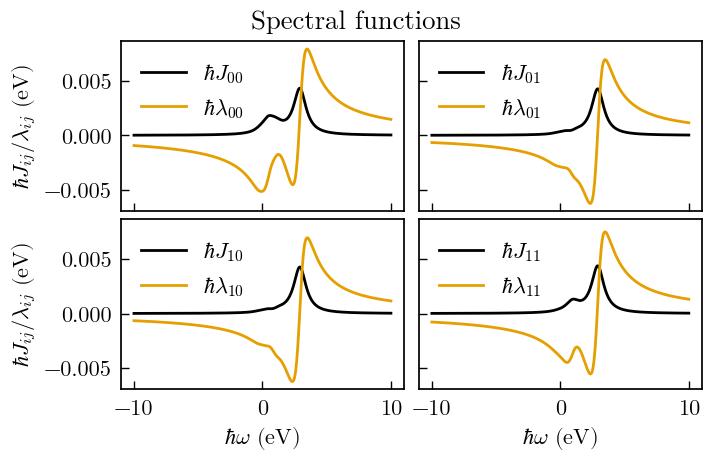

In [14]:
fig, axs = plt.subplots(figsize=(7, 4.5), ncols=nOperators, nrows=nOperators, 
                        sharex=True, sharey=True)
fig.suptitle("Spectral functions")

for i, (axsi, Ji, Li) in enumerate(zip(axs, J, L)):
    for j, (axij, Jij, Lij) in enumerate(zip(axsi, Ji, Li)):
        axij.plot(energy, Jij(energy), label=f"$\hbar J_{{{i}{j}}}$")
        axij.plot(energy, Lij(energy), label=f"$\hbar \lambda_{{{i}{j}}}$")
        axij.legend()
for ax in axs[-1, :]:
    ax.set_xlabel("$\hbar\omega$ (eV)")
for ax in axs[:, 0]:
    ax.set_ylabel("$\hbar J_{ij}/\lambda_{ij}$ (eV)")

In [15]:
# initial state: chosen randomly
psi0 = 0
for i in range(nLevels):
    psi0 += np.random.rand() * basis(nLevels, i)
psi0 = psi0.unit()

# time array
t = np.linspace(0, 200, 1500)

# expectation operators (populations)
e_ops = [basis(nLevels, i) * basis(nLevels, i).dag() for i in range(nLevels)]

# 1. Old Bloch-Redfield
# without cross-correlations
rhoBR_LS = old_brmesolve(H=H, psi0=psi0, tlist=t, a_ops=a_ops, spectra_cb=Si2L, e_ops=e_ops, use_secular=False).expect

# 2. Arithmetic-Geometric master equation 
# with cross-correlations
rhoAG = mesolveAG(H=H, psi0=psi0, tlist=t, a_ops=a_ops, J=J, L=L, e_ops=e_ops, use_secular=False).expect

Text(0.5, 0, '$t$ (fs)')

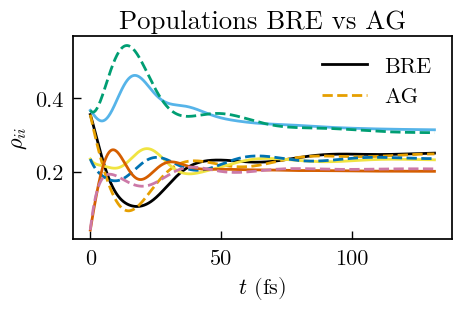

In [16]:
for i, (pBR_LS, pAG) in enumerate(zip(rhoBR_LS, rhoAG)):
    plt.plot(t * inv_eV_to_fs, pBR_LS.real, label="BRE"*(i==0))
    plt.plot(t * inv_eV_to_fs, pAG.real, "--", label="AG"*(i==0))
plt.legend()
plt.title("Populations BRE vs AG")
plt.ylabel(r"$\rho_{ii}$")
plt.xlabel("$t$ (fs)")

In the above figure, we see that the effect of cross-correlations (AG) is quite noticeable when compared to their absence (BRE).